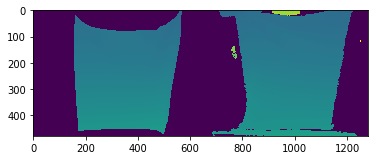

In [26]:
home1 = "/playpen/biao/deformable/output-depth500/"
home2 = "/playpen/biao/camera_transform/data/2018-01-19-00-29-15/depth/"
home3 = "/playpen/biao/result/cat-depth"
home31 = "/playpen/biao/result/cat-depth-1"
home32 = "/playpen/biao/result/cat-depth-2"
import cv2
import matplotlib.pyplot as plt
from util import *
import numpy as np
import os
for i in [home3,home31,home32]:
    if not os.path.exists(i):
        os.mkdir(i)
pics1 = get_filelist(home1)
pics1 = sorted(pics1,key=lambda x: int(os.path.basename(x)[:-4]))
pics2 = get_filelist(home2)
count = 0
for i in range(len(pics1)):
    im1 = cv2.imread(pics1[i],cv2.IMREAD_UNCHANGED)
    im2 = cv2.imread(pics2[i*5],cv2.IMREAD_UNCHANGED)
    im3 = np.concatenate((im1, im2), axis=1)
    cv2.imwrite(os.path.join(home3 + "/%04i.png" % count), im3)
    cv2.imwrite(os.path.join(home31 + "/%04i.png" % count), im1)
    cv2.imwrite(os.path.join(home32 + "/%04i.png" % count), im2)
    count+=1
plt.imshow(im3)
plt.show()

(565, 6) (565, 6)


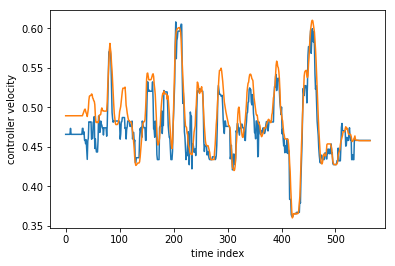

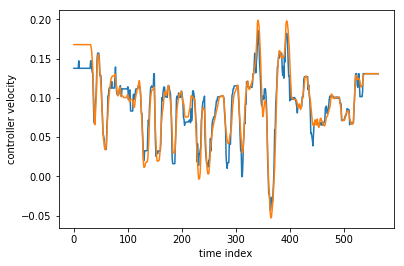

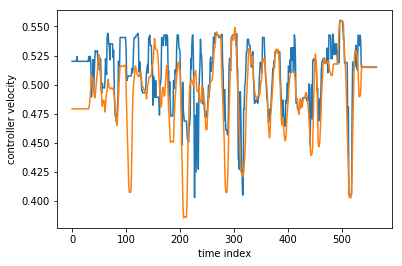

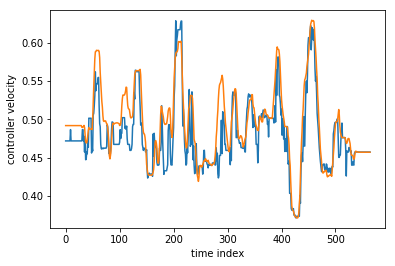

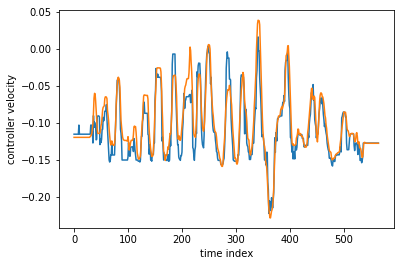

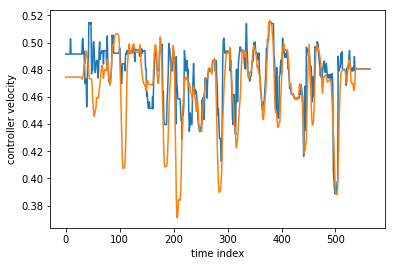

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def vis_depth(vec):
    plt.imshow(vec.reshape(target_size)),plt.show()

    
def nearest_predict(vec,mat,pos):
    vec = vec.astype(int)
    mat = mat.astype(int)
    res = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        vec2= mat[i,:]
        dt = np.sum(abs(vec-vec2))
        res[i]=dt
    # find top answer's indices in mat
    ans = np.argsort(res)[:3]
#     for i in ans:
#         vis_depth(mat[i,:])
    return np.mean(pos[ans], axis=0)

def draw_comparison(y_pred, y):
    for i in range(y_pred.shape[1]):
        axes = plt.gca()
        axes.set_xlabel('time index')
        axes.set_ylabel('controller velocity')
        #axes.set_ylim([-0.3,0.3])
        plt.plot(range(y_pred.shape[0]),y_pred[:,i], label = 'predicted')
        plt.plot(range(y.shape[0]),y[:,i], label = 'ground truth')
        plt.show()
import os
os.chdir('/home/rmqlife/work_remote/office/')
depth1 = np.load('result/depth1.npy')
depth2 = np.load('result/depth2.npy')
y = np.load('result/data.npz')['pos']
y_pred = np.zeros(y.shape)
for i in range(depth2.shape[0]):
    #vis_depth(depth2[i,:])
    y_pred[i,:] = nearest_predict(vec=depth2[i,:],mat=depth1,pos=y)
    #print(y_pred[i,:])
print(y.shape,y_pred.shape)
draw_comparison(y_pred, y)


(5000, 4096) (1365, 4096)


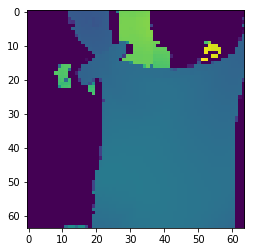

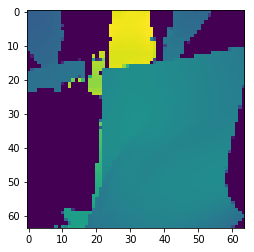

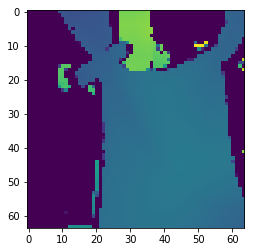

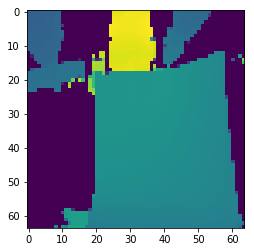

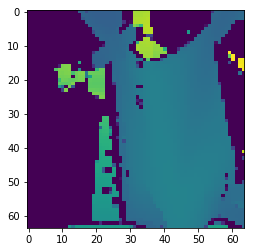

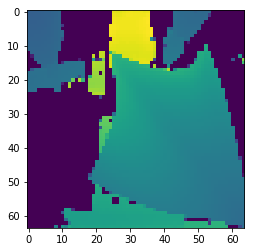

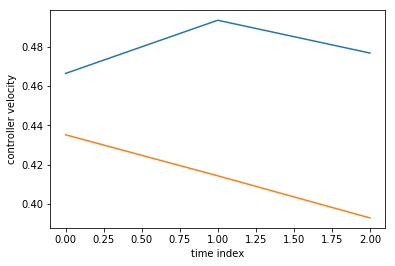

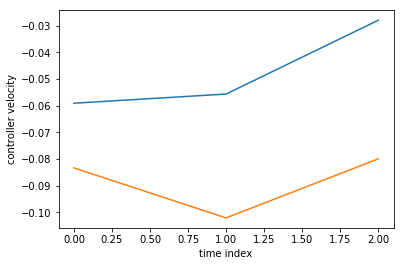

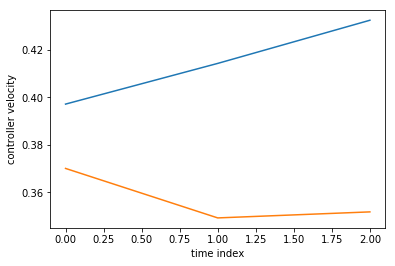

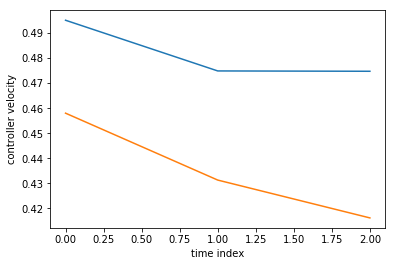

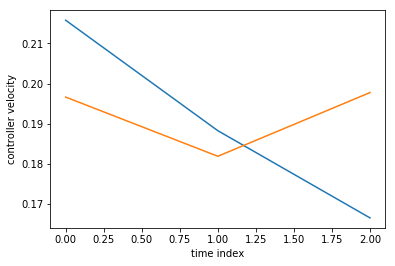

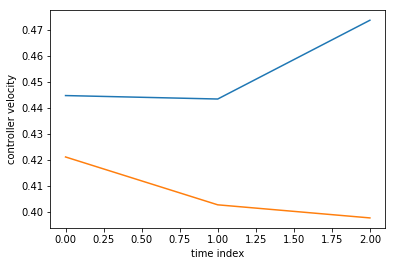

0.13970981929313125


In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def vis_depth(vec):
    target_size = (64,64)
    plt.imshow(vec.reshape(target_size)),plt.show()

    
def nearest_predict(vec,mat,pos):
    vec = vec.astype(int)
    mat = mat.astype(int)
    res = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        vec2= mat[i,:]
        dt = np.sum(abs(vec-vec2))
        res[i]=dt
    # find top answer's indices in mat
    ans = np.argsort(res)[:10]
#     for i in ans:
#         vis_depth(mat[i,:])
    return np.mean(pos[ans], axis=0), ans[0]

def draw_comparison(y_pred, y):
    for i in range(y_pred.shape[1]):
        axes = plt.gca()
        axes.set_xlabel('time index')
        axes.set_ylabel('controller velocity')
        #axes.set_ylim([-0.3,0.3])
        plt.plot(range(y_pred.shape[0]),y_pred[:,i], label = 'predicted')
        plt.plot(range(y.shape[0]),y[:,i], label = 'ground truth')
        plt.show()

class Nearest:
    def __init__(self, arr):
        self.tree=cKDTree(arr,leafsize=1)
    def findNeigh(self, dat):
        ret=self.tree.query(dat,k=1,distance_upper_bound=1.0e15)
        return ret[0],ret[1]

import os
import numpy as np
def exchange_hands(pos):
    return np.hstack((pos[:,-3:],pos[:,:3]))

use_simple=True

sim_dir = '22/fix5'
depth_sim = np.load(os.path.join(sim_dir,'depth_sim_bg.npy'))
if use_simple:
    nn = Nearest(depth_sim)
pos_sim = np.load(os.path.join(sim_dir,'handles.npy'))[:,-6:]


orig_dir = '19'
depth_orig = np.load(os.path.join(orig_dir,'depth_orig.npy'))
pos_orig = np.load(os.path.join(orig_dir,'robot_pos.npy'))
pos_orig = exchange_hands(pos_orig)

# depth_sim = np.load('realtest/depth_sim_real.npy')
# pos_sim = np.load('realtest/handles.npy')[:,-6:]

print(depth_sim.shape, depth_orig.shape)
from util import *
y_pred = np.array([])
y = np.array([])

for i in range(0,pos_orig.shape[0],500):
    if use_simple:
        pred, ans = nearest_predict(vec=depth_orig[i,:]
                                  ,mat=depth_sim
                                  ,pos=pos_sim)
    else:
        dist, ans = nn.findNeigh(depth_orig[i,:])
        pred = pos_sim[ans]
    if True:
        vis_depth(depth_orig[i,:])
        vis_depth(depth_sim[ans,:])
    y = stack_vector(y, pos_orig[i,:])
    y_pred = stack_vector(y_pred, pred)
draw_comparison(y, y_pred)
#draw_comparison(pos_orig,pos_handles)
print(max(np.linalg.norm(pos_orig-pos_orig[1],axis=1)))

565


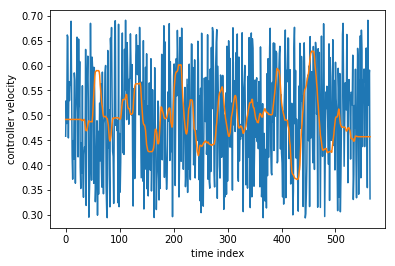

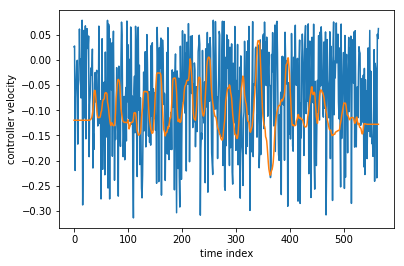

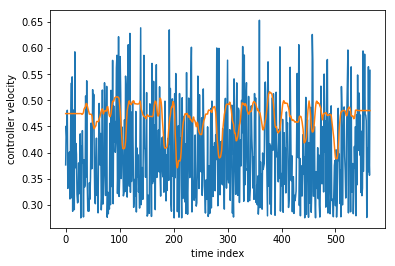

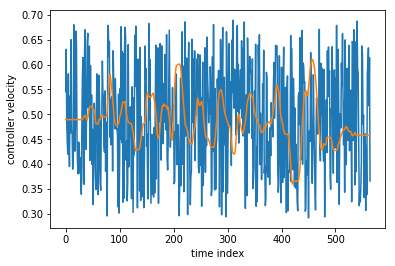

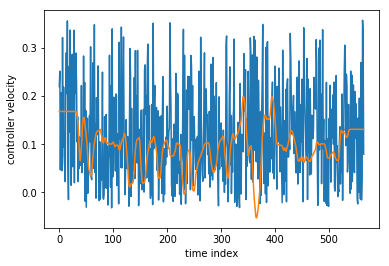

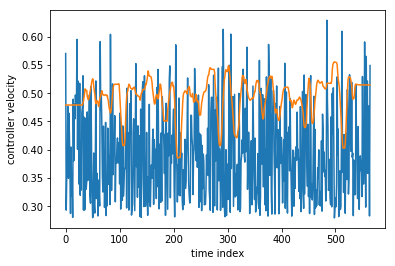

In [47]:
import numpy as np
class Handles:
    def __init__(self,cloth_x, cloth_y, handles, ext=0.1):
        self.cloth_x = cloth_x
        self.cloth_y = cloth_y
        self.init_handles = np.array(handles)
        self.ext = ext
        
    def noisen(self,x,n):
        from random import uniform
        ret = np.zeros(n)
        for i in range(n):
            ret[i]=uniform(-x,x)
        return ret

    def dist3d(self,p1,p2):
        return np.linalg.norm(np.subtract(p1,p2))

    def random_handles(self):
        while True:
            handles = self.init_handles.copy()
            for i in range(handles.shape[0]):
                handles[i,:] += self.noisen(x=0.2, n=3) 
            valid = 1
            valid &= self.dist3d(handles[0],handles[1])<self.cloth_x + self.ext
            valid &= self.dist3d(handles[2],handles[3])<self.cloth_x + self.ext
            valid &= self.dist3d(handles[0],handles[2])<self.cloth_y + self.ext
            valid &= self.dist3d(handles[1],handles[3])<self.cloth_y + self.ext
            #print(self.dist3d(handles[0],handles[2]),valid)
            if valid==1:
                break
        return handles
    
    def random_robot(self):
        while True:
            handles = self.init_handles.copy()
            for i in range(handles.shape[0]):
                handles[i,:] += self.noisen(x=0.2, n=3) 
            valid = 1
            valid &= self.dist3d(handles[2],handles[3])<self.cloth_x + self.ext
            #print(self.dist3d(handles[0],handles[2]),valid)
            if valid==1:
                break
        return handles
    
    def random_hands(self):
        while True:
            handles = self.init_handles.copy()
            for i in range(handles.shape[0]):
                handles[i,:] += self.noisen(x=0.2, n=3) 
            valid = 1
            valid &= self.dist3d(handles[0],handles[1])<self.cloth_x + self.ext
            #print(self.dist3d(handles[0],handles[2]),valid)
            if valid==1:
                break
        return handles
    
    def series(self,pos_num):
        tt_handles = np.zeros((pos_num,4*3))
        tt_handles[0,:] = np.array(handles).reshape(-1,)
        print(pos_num)
        for i in range(0,pos_num):
            #print(tt_pos)
            res = self.random_handles()
            tt_handles[i,:] = res.reshape(-1,)
        return tt_handles
        
cloth_x = 0.3
cloth_y = 0.35
rr = [0.48943184,0.1678617,0.47914139]
rl = [0.4918203,-0.11984081,0.47457296]
hl = [0.55830802,-0.17057873,0.06070259]
hr = [0.54702463,0.16470575,0.01352225]
robot_pos=[rl,rr]
hands_pos=[hl,hr]
handles = np.array(hands_pos + robot_pos)
Handles = Handles(cloth_x=cloth_x, cloth_y=cloth_y, handles=handles)

#pos1 = np.load('/playpen/biao/result/0130/merged3/handles.npy')[:,-6:]
pos2 = np.load('/home/rmqlife/work_remote/office/result/data.npz')['pos']

pos1 = Handles.series(pos_num=pos2.shape[0])[:,-6:]
pos2 = np.hstack((pos2[:,-3:],pos2[:,:3]))

draw_comparison(pos1,pos2)